In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# ===========================================================================
# Copyright (C) 2022 Infineon Technologies AG
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
# 2. Redistributions in binary form must reproduce the above copyright
#    notice, this list of conditions and the following disclaimer in the
#    documentation and/or other materials provided with the distribution.
# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.
# ===========================================================================

import numpy as np
from ifxAvian import Avian
from scipy import signal
import matplotlib.pyplot as plt

print("Radar SDK Version: " + Avian.get_version())

RX1_data = []
RX2_data = []
RX3_data = []


Radar SDK Version: 3.4.0


In [10]:
# ===========================================================================
# Copyright (C) 2021 Infineon Technologies AG
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice,
#    this list of conditions and the following disclaimer.
# 2. Redistributions in binary form must reproduce the above copyright
#    notice, this list of conditions and the following disclaimer in the
#    documentation and/or other materials provided with the distribution.
# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.
# ===========================================================================

import numpy as np

def fft_spectrum(mat, range_window):
    # Calculate fft spectrum
    # mat:          chirp data
    # range_window: window applied on input data before fft

    # received data 'mat' is in matrix form for a single receive antenna
    # each row contains 'chirpsamples' samples for a single chirp
    # total number of rows = 'numchirps'

    # -------------------------------------------------
    # Step 1 - remove DC bias from samples
    # -------------------------------------------------
    [numchirps, chirpsamples] = np.shape(mat)

    # helpful in zero padding for high resolution FFT.
    # compute row (chirp) averages
    avgs = np.average(mat,1).reshape(numchirps,1)

    #de-bias values
    mat = mat - avgs
    # -------------------------------------------------
    # Step 2 - Windowing the Data
    # -------------------------------------------------
    mat = np.multiply(mat,range_window)

    # -------------------------------------------------
    # Step 3 - add zero padding here
    # -------------------------------------------------
    zp1 = np.pad(mat,((0,0),(0,chirpsamples)),'constant')

    # -------------------------------------------------
    # Step 4 - Compute FFT for distance information
    # -------------------------------------------------
    range_fft = np.fft.fft(zp1)/chirpsamples

    #ignore the redundant info in negative spectrum
    #compensate energy by doubling magnitude
    range_fft = 2*range_fft[:,range(int(chirpsamples))]

    return range_fft
        

In [11]:
# mti_alpha = 0.8 # moving target indicator
# num_ant = 3
# mti_history = np.zeros((num_chirps_per_frame, num_samples_per_chirp, num_ant))

In [12]:
def compute_doppler_map(data : np.ndarray, i_ant : int):
    mti_alpha = 0.8 # moving target indicator
    num_ant = 3
    mti_history = np.zeros((num_chirps_per_frame, num_samples_per_chirp, num_ant))
    """Compute Range-Doppler map for i-th antennas
    
    Parameter:
        - data:     Raw-data for one antenna (dimension:
                    num_chirps_per-frame x num_samples_per_chirp)
        - i_ant:    Number of antenna
    """
    # Step 1 - Remove average from signal (mean removal)
    data = data - np.average(data)

    # Step 2 - MTI processing to remove static objects
    data_mti = data - mti_history[:,:,i_ant]
    mti_history[:,:,i_ant] = data*mti_alpha + mti_history[:,:,i_ant]*(1-mti_alpha)

    # Step 3 - calculate fft spectrum for the frame
    fft1d = fft_spectrum(data_mti, range_window)

    # prepare for doppler FFT

    # Transpose
    # Distance is now indicated on y axis
    fft1d = np.transpose(fft1d)

    # Step 4 - Windowing the Data in doppler
    fft1d = np.multiply(fft1d,doppler_window)

    zp2 = np.pad(fft1d,((0,0),(0,num_chirps_per_frame)), "constant")
    fft2d = np.fft.fft(zp2)/num_chirps_per_frame

    # re-arrange fft result for zero speed at centre
    return np.fft.fftshift(fft2d,(1,))

In [13]:
class Draw:
    # Represents drawing for example
    #
    # Draw is done for each antenna, and each antenna is represented for
    # other subplot

    def __init__(self, max_speed_m_s, max_range_m, num_ant):
        # max_range_m:   maximum supported range
        # max_speed_m_s: maximum supported speed
        # num_ant:       Number of antennas
        self._h = []
        self._max_speed_m_s = max_speed_m_s
        self._max_range_m = max_range_m
        self._num_ant = num_ant

        self._fig, ax = plt.subplots(nrows=1, ncols=num_ant, figsize=((num_ant+1)//2,2))
        if(num_ant==1):
            self._ax = [ax]
        else:
            self._ax = ax

        self._fig.canvas.manager.set_window_title("Doppler")
        self._fig.set_size_inches(3*num_ant+1, 3+1/num_ant)
        self._fig.canvas.mpl_connect('close_event', self.close)
        self._is_window_open = True

    def _draw_first_time(self, data_all_antennas):
        # First time draw
        #
        # It computes minimal, maximum value and draw data for all antennas
        # in same scale
        # data_all_antennas: array of raw data for each antenna

        minmin = min([np.min(data) for data in data_all_antennas])
        maxmax = max([np.max(data) for data in data_all_antennas])

        for i_ant in range(self._num_ant):
            data = data_all_antennas[i_ant]
            h = self._ax[i_ant].imshow(
                        data,
                        vmin=minmin, vmax=maxmax,
                        cmap='jet',
                        extent=(    -self._max_speed_m_s,
                                    self._max_speed_m_s,
                                    0,
                                    self._max_range_m),
                        origin='lower')
            self._h.append(h)

            self._ax[i_ant].set_xlabel("velocity (m/s)")
            self._ax[i_ant].set_ylabel("distance (m)")
            self._ax[i_ant].set_title("antenna #"+str(i_ant))
        self._fig.subplots_adjust(right=0.8)
        cbar_ax = self._fig.add_axes([0.85, 0.0, 0.03, 1])

        cbar =self._fig.colorbar(self._h[0], cax=cbar_ax)
        cbar.ax.set_ylabel("magnitude (dB)")

    def _draw_next_time(self, data_all_antennas):
        # Update data for each antenna

        for i_ant in range(0, self._num_ant):
            data = data_all_antennas[i_ant]
            self._h[i_ant].set_data(data)

    def draw(self, data_all_antennas):
        # Draw data for all antenna
        if self._is_window_open:
            first_run = len(self._h) == 0
            if first_run:
                self._draw_first_time(data_all_antennas)
            else:
                self._draw_next_time(data_all_antennas)

            # Needed for Matplotlib ver: 3.4.0 and 3.4.1 helps with capture closing event
            plt.draw()
            plt.pause(1e-3)

    def close(self, event = None):
        if self.is_open():
            self._is_window_open = False
            plt.close(self._fig)
            plt.close('all')
            print('Application closed!')

    def is_open(self):
        return self._is_window_open
# -------------------------------------------------
# Helpers
# -------------------------------------------------
def parse_attr_nframes_frate( description, def_nframes, def_frate):
    # Parse all program attributes
    # description:   describes program
    # def_nframes:   default number of frames
    # def_frate:     default frame rate in Hz
    parser = argparse.ArgumentParser(
        description=description)

    parser.add_argument('-n', '--nframes', type=int,
                        default=def_nframes, help="number of frames, default "+str(def_nframes))
    parser.add_argument('-f', '--frate', type=int, default=def_frate,
                        help="frame rate in Hz, default "+str(def_frate))

    return parser.parse_args()

def linear_to_dB(x):
    return 20*np.log10(abs(x))

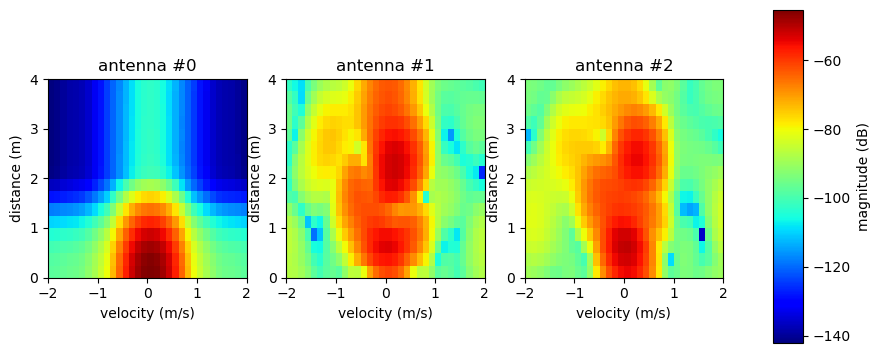

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Application closed!


In [14]:
with Avian.Device() as device:
    # set device config
    num_rx_antennas = device.get_sensor_information()["num_rx_antennas"]
    rx_mask = (1 << num_rx_antennas) - 1
    
#     configR1 = device.get_config_defaults()

#     metric = Avian.DeviceMetrics(
#         sample_rate_Hz =           1_000_000,
#         range_resolution_m =       0.033,
#         max_range_m =              4,
#         max_speed_m_s =            2,
#         speed_resolution_m_s =     0.31,
#         frame_repetition_time_s =  1/25,
#         center_frequency_Hz =      60_750_000_000,
#         rx_mask =                  rx_mask,
#         tx_mask =                  1,
#         tx_power_level =           31,
#         if_gain_dB =               33
#     )

    configR1 = Avian.DeviceConfig(
    sample_rate_Hz = 1_000_000,       # ADC sample rate of 1MHZ
    rx_mask = 7,                      # activate RX1 and RX3 AND RX2
    tx_mask = 1,                      # activate TX1
    if_gain_dB = 33,                  # gain of 33dB
    tx_power_level = 31,              # TX power level of 31
    start_frequency_Hz = 59.5e9,        #B=1.43GHz 
    end_frequency_Hz = 60.93e9,        
    num_chirps_per_frame = 16,       # 16 chirps per frame
    num_samples_per_chirp = 16,       # 64 samples per chirp
    chirp_repetition_time_s = 1240e-6, # 1240 us
    frame_repetition_time_s = 0.1,    # , frame_Rate = 25Hz
    hp_cutoff_Hz = 45_000,            # 80kHz cutoff frequency for high-pass filter
    aaf_cutoff_Hz = 500_000,          # Anti-aliasing cutoff frequency of 500kHz
    mimo_mode = 'off'                 # MIMO disabled
    )
    
    max_range_m =              4 # for graph only
    max_speed_m_s =            2 # for graph only
#     configR1 = device.metrics_to_config(metric)

    device.set_config(configR1)
    num_chirps_per_frame = configR1.num_chirps_per_frame
    num_samples_per_chirp = configR1.num_samples_per_chirp
    range_window = signal.blackmanharris(num_samples_per_chirp).reshape(1,num_samples_per_chirp)
    doppler_window = signal.blackmanharris(num_chirps_per_frame).reshape(1,num_chirps_per_frame)
    draw = Draw(
        max_speed_m_s, \
        max_range_m, \
        num_rx_antennas)

    no_of_frames = 10 # recording for 1 second
    
    for frame_number in range(no_of_frames): # For each frame
        if not draw.is_open():
            break

        frame_data = device.get_next_frame()
        RX1_data.append(frame_data[0])
        RX2_data.append(frame_data[1])
        RX3_data.append(frame_data[2])

        data_all_antennas = []



        for i_ant in range(0, num_rx_antennas): #For each antenna
            mat = frame_data[i_ant, :, :]
            dfft_dbfs = linear_to_dB(compute_doppler_map(mat, i_ant))
            data_all_antennas.append(dfft_dbfs)
        draw.draw(data_all_antennas);

    draw.close();

# raw data for all 3 antenna per frame

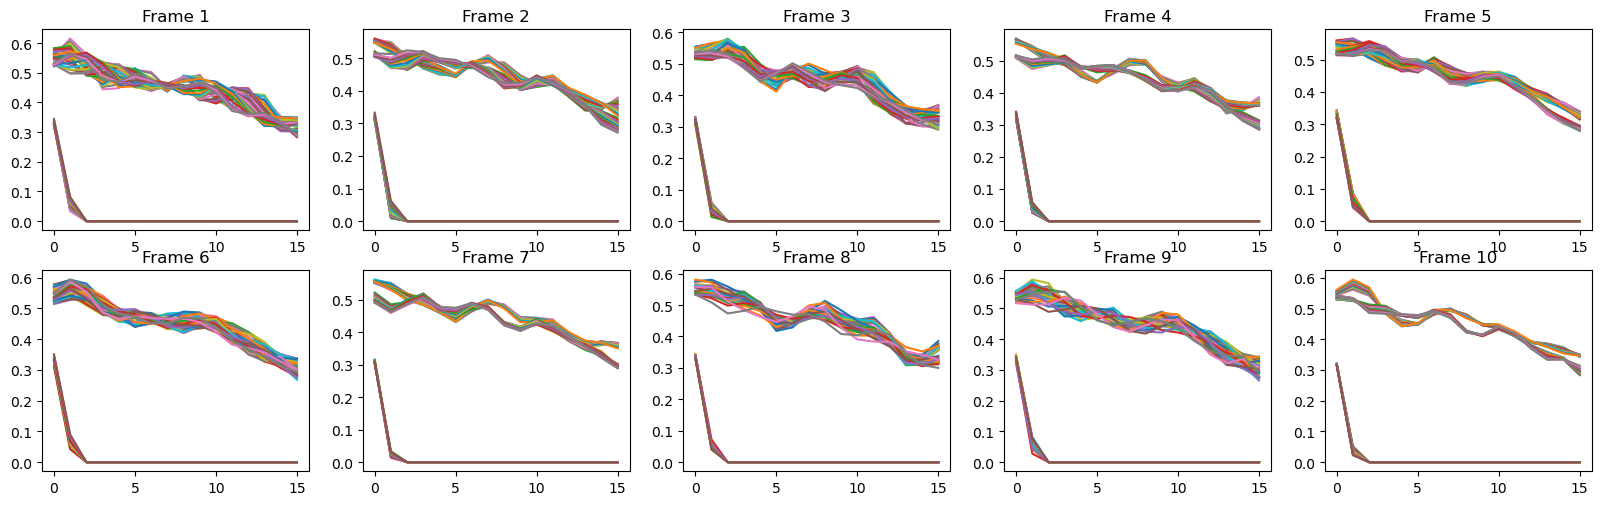

In [15]:
plt.figure(figsize=(20,12))

for f in range(len(RX1_data)):
    plt.subplot(4,5,f+1)
    a = "Frame "+str(f+1)
    plt.title(a)

    for i in range(len(RX1_data[f])):
        plt.plot(RX1_data[f][i]); # one chirp out of 16


    for i in range(len(RX2_data[f])):
        plt.plot(RX2_data[f][i]); # one chirp out of 16


    for i in range(len(RX3_data[f])):
        plt.plot(RX3_data[f][i]); # one chirp out of 16
    

In [16]:
print("total number of frame = ",len(RX2_data)) # number of frames
print("total number of chirps",len(RX1_data[0]) )# number of chirps per frame)
print("total number of samples per chirp", len(RX2_data[0][0])) # number of samples per chirp)

total number of frame =  10
total number of chirps 16
total number of samples per chirp 16


# range profiles

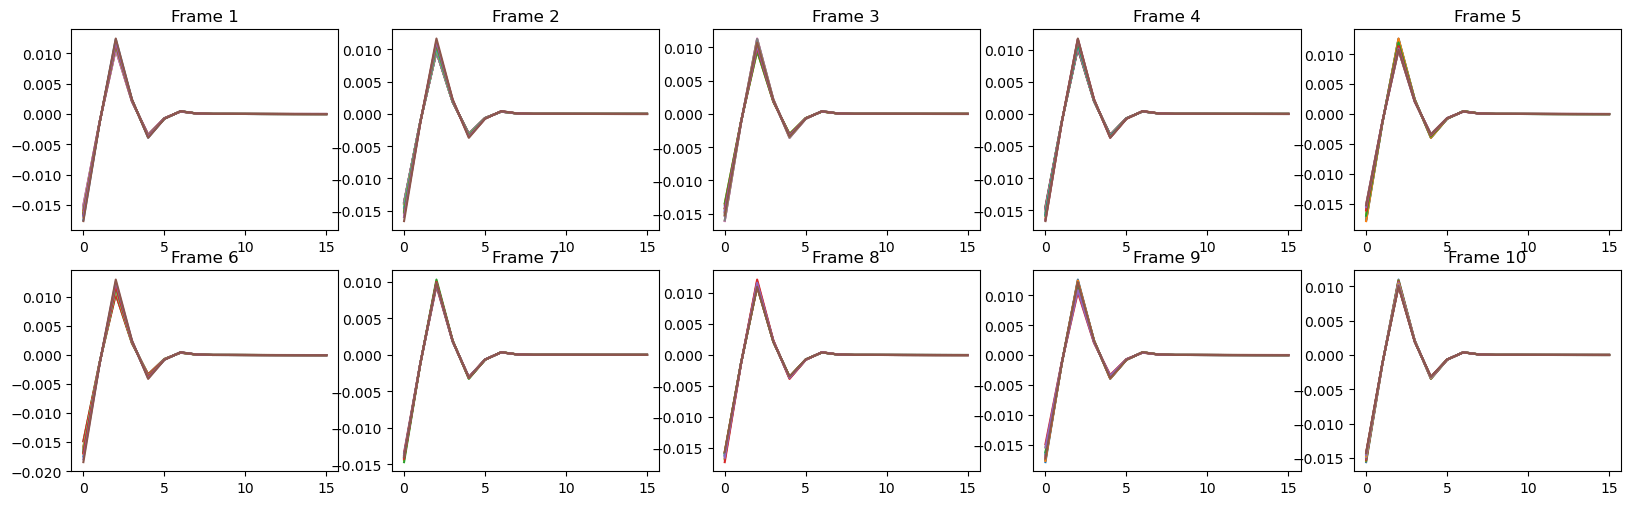

In [17]:
# RANGE PROFILE RX1
FFTRX1_list = []

plt.figure(figsize=(20,12))
for f in range(len(RX1_data)):
    plt.subplot(4,5,f+1)
    a = "Frame "+str(f+1)
    plt.title(a)
    
    FFTRX1 = fft_spectrum(RX1_data[f],range_window)
    FFTRX1_list.append(FFTRX1)
    for i in range(len(RX1_data[0])):
        plt.plot(FFTRX1[i]);

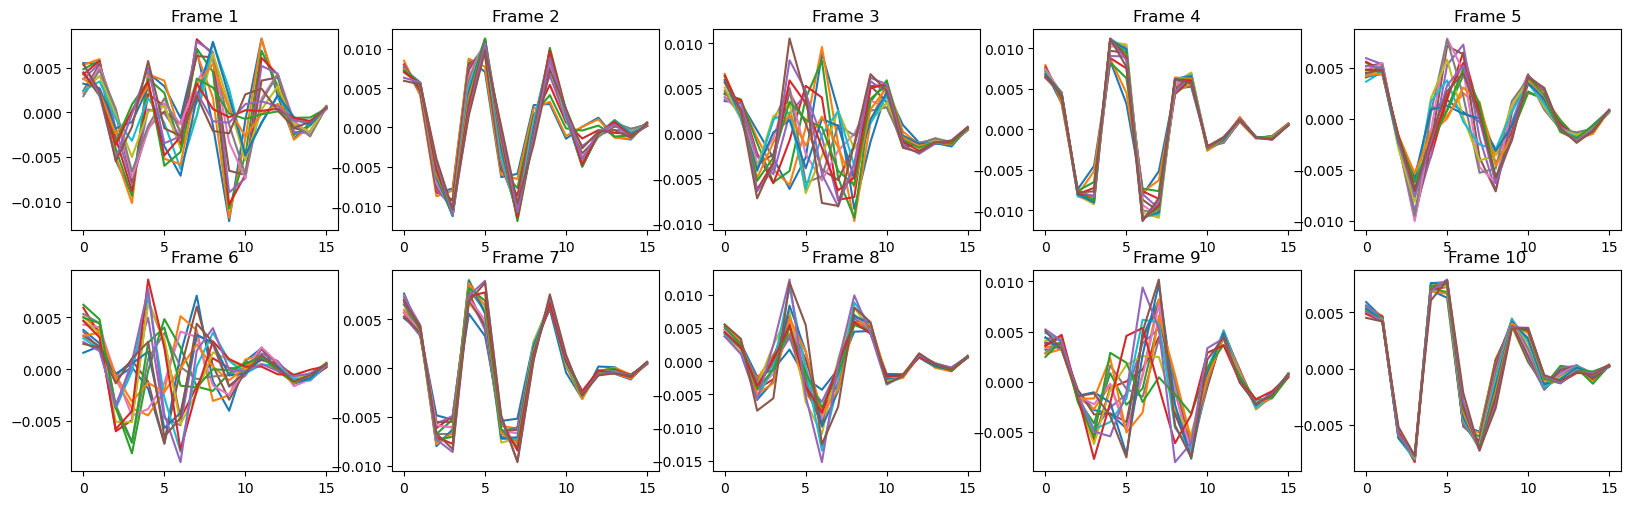

In [18]:
# RANGE PROFILE RX2
FFTRX2_list = []

plt.figure(figsize=(20,12))
for f in range(len(RX2_data)):
    plt.subplot(4,5,f+1)
    a = "Frame "+str(f+1)
    plt.title(a)
    
    FFTRX2 = fft_spectrum(RX2_data[f],range_window)
    FFTRX2_list.append(len(RX2_data[0]))
    for i in range(16):
        plt.plot(FFTRX2[i]);

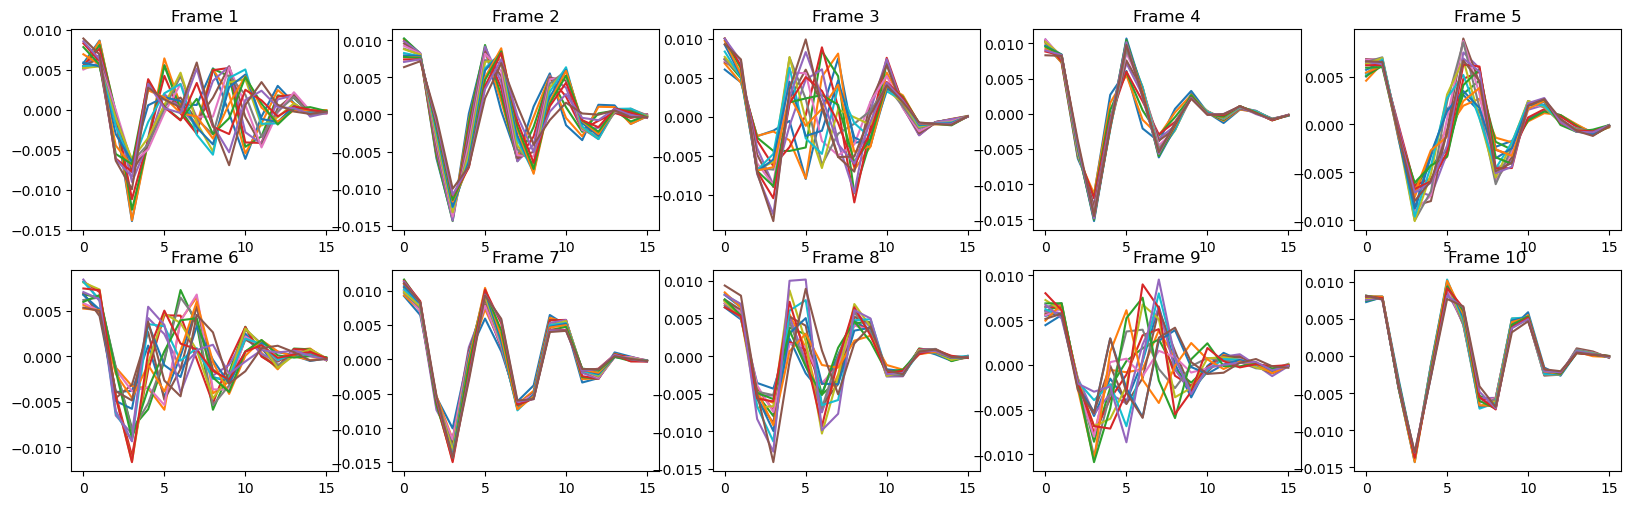

In [19]:
# RANGE PROFILE RX3
FFTRX3_list = []

plt.figure(figsize=(20,12))
for f in range(len(RX3_data)):
    plt.subplot(4,5,f+1)
    a = "Frame "+str(f+1)
    plt.title(a)
    
    FFTRX3 = fft_spectrum(RX3_data[f],range_window)
    FFTRX3_list.append(FFTRX3)
    for i in range(len(RX3_data[0])):
        plt.plot(FFTRX3[i]);

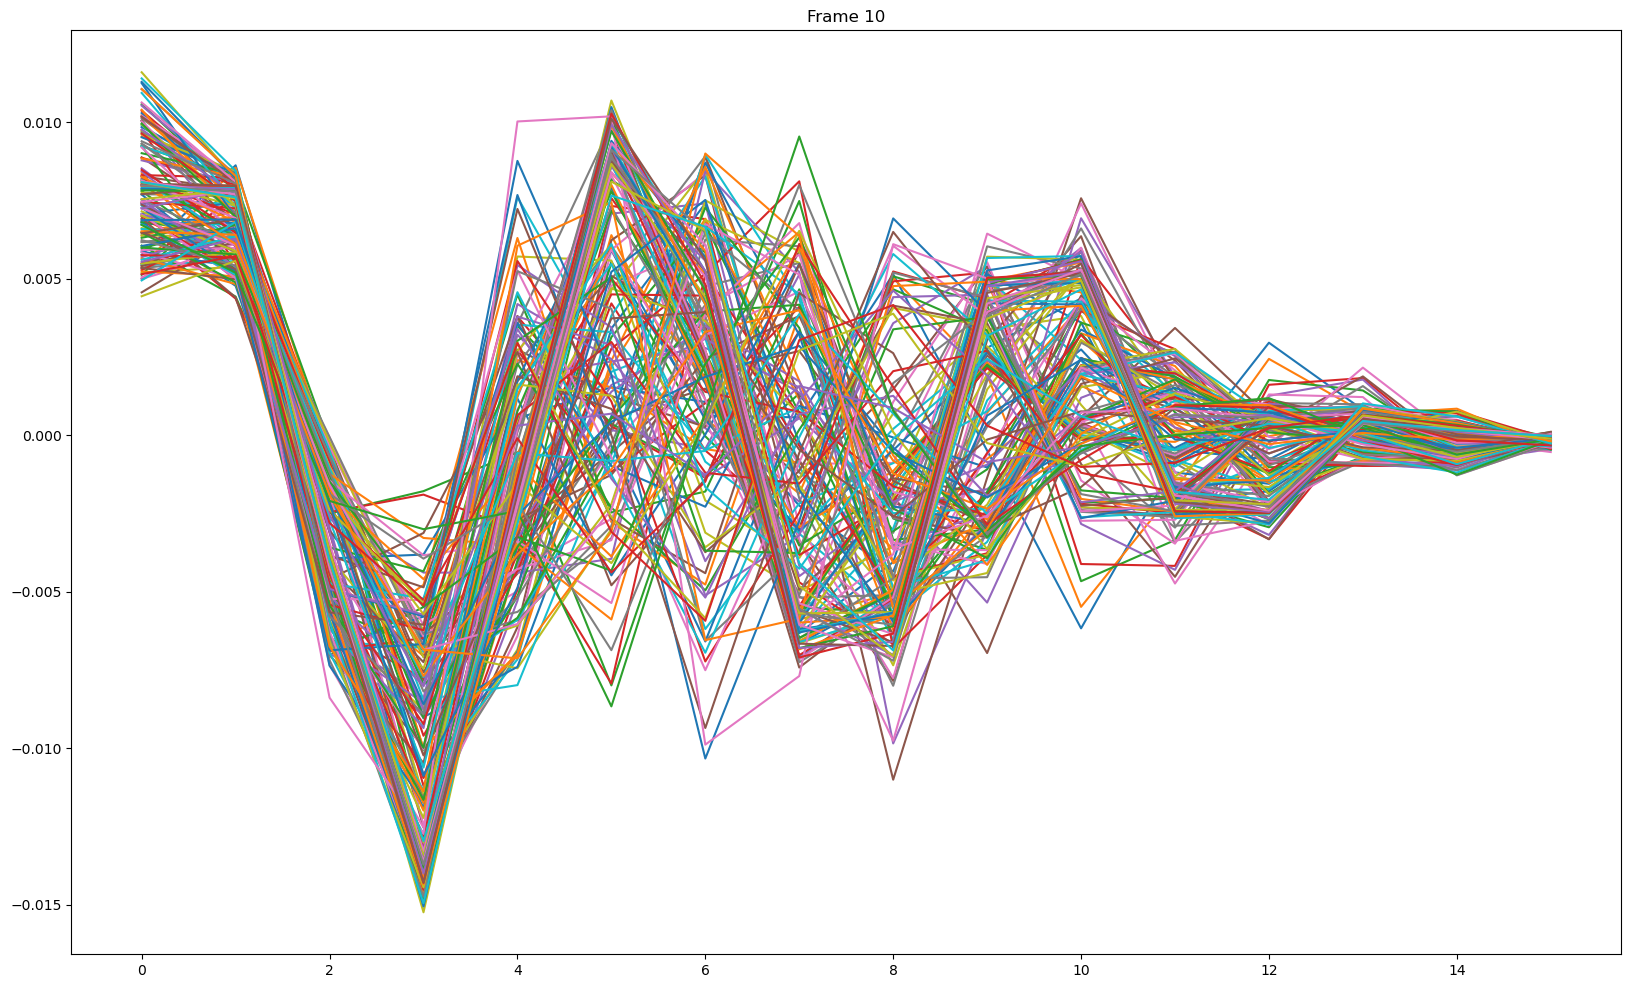

In [20]:
##################
FFTRX3_list = []

plt.figure(figsize=(20,12))
for f in range(len(RX3_data)):
#     plt.subplot(4,5,f+1)
    a = "Frame "+str(f+1)
    plt.title(a)
    
    FFTRX3 = fft_spectrum(RX3_data[f],range_window)
    FFTRX3_list.append(FFTRX3)
    for i in range(16):
        plt.plot(FFTRX3[i]);
##################

# doppler profiles

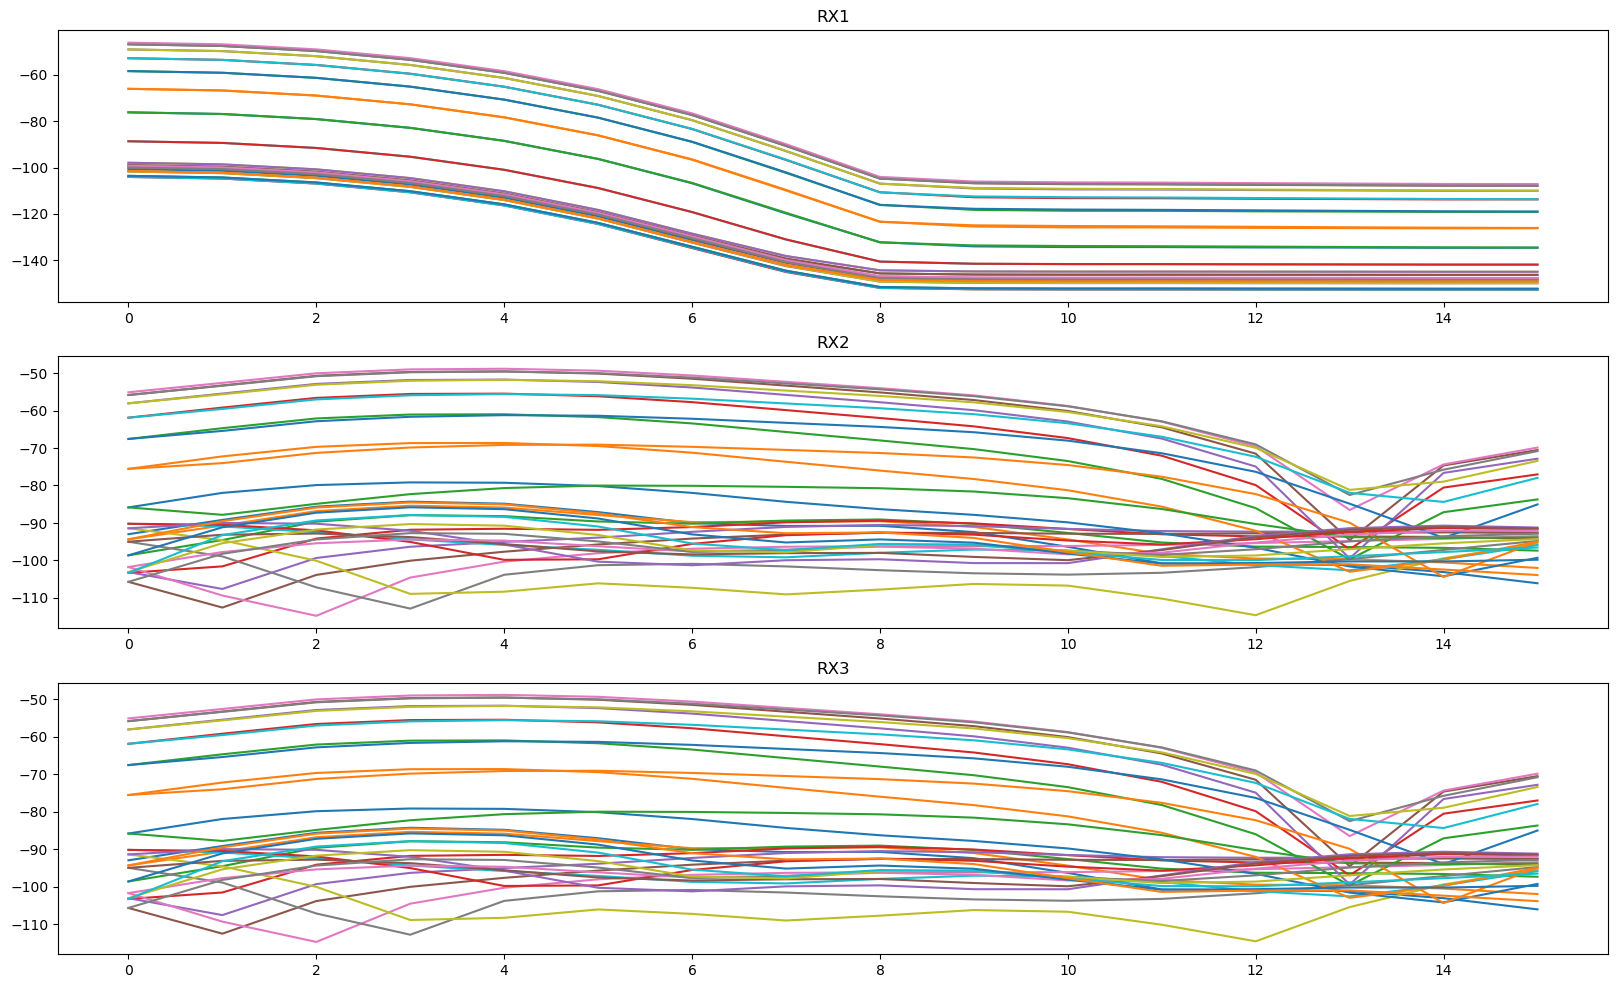

In [21]:
doppRX1 = []
doppRX2 = []
doppRX3 = []
dopp_all_antennas = []

for i_ant in range(0, num_rx_antennas): #For each antenna
    mat = frame_data[i_ant, :, :]
    dfft_dbfs = linear_to_dB(compute_doppler_map(mat, i_ant))
    dopp_all_antennas.append(dfft_dbfs)
    if i_ant==0:
        doppRX1.append(dfft_dbfs)
    if i_ant==1:
        doppRX2.append(dfft_dbfs)
    if i_ant==2:
        doppRX3.append(dfft_dbfs)
    
    
plt.figure(figsize=(20,12))

plt.subplot(3,1,1)
plt.plot(doppRX1[0])
plt.title("RX1")
plt.subplot(3,1,2)
plt.plot(doppRX2[0])
plt.title("RX2")
plt.subplot(3,1,3)
plt.plot(doppRX2[0])
plt.title("RX3")
plt.show()

In [22]:
data = []
data.append(np.ndarray.flatten(doppRX1[0]))
data.append(np.ndarray.flatten(doppRX2[0]))
data.append(np.ndarray.flatten(doppRX3[0]))
data = np.array(data)
data = np.ndarray.flatten(data)
data = np.float16(data)


In [23]:
label = "LEFT"
Columns = []
for i in range(len(data-1)):
    s = "Sample " + str(i)
    Columns.append(s)
Columns.append('GESTURE')

In [24]:
data = data.astype(object)
data = np.append(data,label)
data

array([-100.6875, -101.5, -103.5625, ..., -99.375, -98.25, 'LEFT'],
      dtype=object)

In [25]:
import csv
# Open the CSV file in write mode
with open('datasetT.csv', 'w', newline='') as file:
    # Create a writer object
    writer = csv.writer(file)

    # Write a column header to the CSV file
    writer.writerow(Columns)
    

In [26]:
with open('datasetT.csv', 'a', newline='') as file:
    # Create a writer object
    writer = csv.writer(file)

    # Writing data to the CSV file
    writer.writerow(data)

In [27]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.metrics import accuracy_score
# df = pd.read_csv('dataset.csv')
# X = df.drop('GESTURE', axis=1)  # Specify the target column name
# y = df['GESTURE']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# model = GaussianNB()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy:', accuracy)
# import joblib
# joblib.dump(model, 'demo_left_not.pkl')

In [28]:
# model = joblib.load('demo_left_not.pkl')  # Load the saved model file
# df1 = pd.read_csv('datasetT.csv')
# newdata = df1.drop('GESTURE', axis=1)
# newdata
# p = model.predict(newdata)
# p[0]

In [29]:

matff = np.ndarray.flatten(mat)
matff

array([0.53211236, 0.52893776, 0.51306474, 0.50866914, 0.48107448,
       0.47228327, 0.4952381 , 0.47472528, 0.42319903, 0.41465202,
       0.43858364, 0.41123322, 0.3809524 , 0.35775337, 0.33406594,
       0.2832723 , 0.52991456, 0.52551895, 0.50793654, 0.50451773,
       0.48107448, 0.47277167, 0.4942613 , 0.47521368, 0.42539683,
       0.41391942, 0.43785104, 0.40976802, 0.3789988 , 0.35799757,
       0.33748475, 0.2862027 , 0.53040296, 0.52698416, 0.50549453,
       0.50280833, 0.48107448, 0.47179487, 0.4913309 , 0.47423688,
       0.42490843, 0.41416362, 0.43711844, 0.41025642, 0.37704518,
       0.35726497, 0.33797315, 0.2876679 , 0.52942616, 0.52478635,
       0.50207573, 0.50036633, 0.48058608, 0.47228327, 0.4908425 ,
       0.47692308, 0.42588523, 0.41367522, 0.43467644, 0.4092796 ,
       0.37557998, 0.35750917, 0.33992675, 0.2896215 , 0.53284496,
       0.52649575, 0.50402933, 0.50061053, 0.48156288, 0.47179487,
       0.4888889 , 0.47716728, 0.42735043, 0.41367522, 0.43467

In [30]:
len(matff)

256

In [31]:
1+1

2

In [44]:
mat[0] ==RX1_data

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal